<h1>ACDC Main Demo</h1>

<p>This notebook (which doubles as a script) shows several use cases of ACDC</p>

<p>The codebase is built on top of https://github.com/neelnanda-io/TransformerLens (source version)</p>

<h3>Setup:</h3>
<p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

In [1]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    import subprocess # to install graphviz dependencies
    command = ['apt-get', 'install', 'graphviz-dev']
    subprocess.run(command, check=True)

    import os # make images folder
    os.mkdir("ims/")

    from IPython import get_ipython
    ipython = get_ipython()

    ipython.run_line_magic( # install ACDC
        "pip",
        "install git+https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git@d89f7fa9cbd095202f3940c889cb7c6bf5a9b516",
    )

except Exception as e:
    IN_COLAB = False
    print("Running outside of colab")

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    import os # make images folder
    if not os.path.exists("ims/"):
        os.mkdir("ims/")

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        print("Running as a notebook")
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore
    else:
        print("Running as a script")

Running outside of colab
Running as a notebook


<h2>Imports etc</h2>

In [2]:
import wandb
import IPython
from IPython.display import Image, display
import torch
import gc
from tqdm import tqdm
import networkx as nx
import os
import torch
import huggingface_hub
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from tqdm import tqdm
import yaml
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens.HookedTransformer import (
    HookedTransformer,
)
try:
    from acdc.tracr_task.utils import (
        get_all_tracr_things,
        get_tracr_model_input_and_tl_model,
    )
except Exception as e:
    print(f"Could not import `tracr` because {e}; the rest of the file should work but you cannot use the tracr tasks")
from acdc.docstring.utils import get_all_docstring_things
from acdc.acdc_utils import (
    make_nd_dict,
    reset_network,
    shuffle_tensor,
    cleanup,
    ct,
    TorchIndex,
    Edge,
    EdgeType,
)  # these introduce several important classes !!!

from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.TLACDCExperiment import TLACDCExperiment

from acdc.acdc_utils import (
    kl_divergence,
)
from acdc.ioi.utils import (
    get_all_ioi_things,
    get_gpt2_small,
)
from acdc.induction.utils import (
    get_all_induction_things,
    get_validation_data,
    get_good_induction_candidates,
    get_mask_repeat_candidates,
)
from acdc.greaterthan.utils import get_all_greaterthan_things
from acdc.acdc_graphics import (
    build_colorscheme,
    show,
)
import argparse

torch.autograd.set_grad_enabled(False)

/users/xwang259/.conda/envs/ACDC/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning:

torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.

/users/xwang259/.conda/envs/ACDC/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning:

torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.

/users/xwang259/.conda/envs/ACDC/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning:

torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>ACDC Experiment Setup</h2>
<p>We use a `parser to set all the options for the ACDC experiment.
This is still usable in notebooks! We can pass a string to the parser, see below.
We'll reproduce </p>

In [3]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")

task_choices = ['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan']
parser.add_argument('--task', type=str, required=True, choices=task_choices, help=f'Choose a task from the available options: {task_choices}')
parser.add_argument('--threshold', type=float, required=True, help='Value for THRESHOLD')
parser.add_argument('--first-cache-cpu', type=str, required=False, default="True", help='Value for FIRST_CACHE_CPU (the old name for the `online_cache`)')
parser.add_argument('--second-cache-cpu', type=str, required=False, default="True", help='Value for SECOND_CACHE_CPU (the old name for the `corrupted_cache`)')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--using-wandb', action='store_true', help='Use wandb')
parser.add_argument('--wandb-entity-name', type=str, required=False, default="remix_school-of-rock", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group-name', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project-name', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--indices-mode', type=str, default="normal")
parser.add_argument('--names-mode', type=str, default="normal")
parser.add_argument('--device', type=str, default="cuda")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument("--max-num-epochs",type=int, default=100_000)
parser.add_argument('--single-step', action='store_true', help='Use single step, mostly for testing')
parser.add_argument("--abs-value-threshold", action='store_true', help='Use the absolute value of the result to check threshold')

if ipython is not None:
    # We are in a notebook
    # you can put the command you would like to run as the ... in r"""..."""
    args = parser.parse_args(
        [line.strip() for line in r"""--task=induction\
--zero-ablation\
--threshold=0.71\
--indices-mode=reverse\
--first-cache-cpu=False\
--second-cache-cpu=False\
--max-num-epochs=100000""".split("\\\n")]
    )
else:
    # read from command line
    args = parser.parse_args()

# Process args

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

TASK = args.task
if args.first_cache_cpu is None: # manage default
    ONLINE_CACHE_CPU = True
elif args.first_cache_cpu.lower() == "false":
    ONLINE_CACHE_CPU = False
elif args.first_cache_cpu.lower() == "true":
    ONLINE_CACHE_CPU = True
else: 
    raise ValueError(f"first_cache_cpu must be either True or False, got {args.first_cache_cpu}")
if args.second_cache_cpu is None:
    CORRUPTED_CACHE_CPU = True
elif args.second_cache_cpu.lower() == "false":
    CORRUPTED_CACHE_CPU = False
elif args.second_cache_cpu.lower() == "true":
    CORRUPTED_CACHE_CPU = True
else:
    raise ValueError(f"second_cache_cpu must be either True or False, got {args.second_cache_cpu}")
THRESHOLD = args.threshold  # only used if >= 0.0
ZERO_ABLATION = True if args.zero_ablation else False
USING_WANDB = True if args.using_wandb else False
WANDB_ENTITY_NAME = args.wandb_entity_name
WANDB_PROJECT_NAME = args.wandb_project_name
WANDB_RUN_NAME = args.wandb_run_name
WANDB_GROUP_NAME = args.wandb_group_name
INDICES_MODE = args.indices_mode
NAMES_MODE = args.names_mode
DEVICE = args.device
RESET_NETWORK = args.reset_network
SINGLE_STEP = True if args.single_step else False

<h2>Setup Task</h2>

In [4]:

second_metric = None  # some tasks only have one metric
use_pos_embed = TASK.startswith("tracr")

if TASK == "ioi":
    num_examples = 100
    things = get_all_ioi_things(
        num_examples=num_examples, device=DEVICE, metric_name=args.metric
    )
elif TASK == "tracr-reverse":
    num_examples = 6
    things = get_all_tracr_things(
        task="reverse",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "tracr-proportion":
    num_examples = 50
    things = get_all_tracr_things(
        task="proportion",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "induction":
    num_examples = 10
    seq_len = 300
    things = get_all_induction_things(
        num_examples=num_examples, seq_len=seq_len, device=DEVICE, metric=args.metric
    )
elif TASK == "docstring":
    num_examples = 50
    seq_len = 41
    things = get_all_docstring_things(
        num_examples=num_examples,
        seq_len=seq_len,
        device=DEVICE,
        metric_name=args.metric,
        correct_incorrect_wandb=True,
    )
elif TASK == "greaterthan":
    num_examples = 100
    things = get_all_greaterthan_things(
        num_examples=num_examples, metric_name=args.metric, device=DEVICE
    )
else:
    raise ValueError(f"Unknown task {TASK}")

/users/xwang259/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loaded pretrained model redwood_attn_2l into HookedTransformer


validation_data.pt:   0%|          | 0.00/125M [00:00<?, ?B/s]

mask_repeat_candidates.pkl:   0%|          | 0.00/31.3M [00:00<?, ?B/s]

<p> Let's define the four most important objects for ACDC experiments:

In [5]:

validation_metric = things.validation_metric # metric we use (e.g KL divergence)
toks_int_values = things.validation_data # clean data x_i
toks_int_values_other = things.validation_patch_data # corrupted data x_i'
tl_model = things.tl_model # transformerlens model

if RESET_NETWORK:
    reset_network(TASK, DEVICE, tl_model)

<h2>Setup ACDC Experiment</h2>

In [6]:
# Make notes for potential wandb run
try:
    with open(__file__, "r") as f:
        notes = f.read()
except:
    notes = "No notes generated, expected when running in an .ipynb file"

tl_model.reset_hooks()

# Save some mem
gc.collect()
torch.cuda.empty_cache()

# Setup wandb if needed
if WANDB_RUN_NAME is None or IPython.get_ipython() is not None:
    WANDB_RUN_NAME = f"{ct()}{'_randomindices' if INDICES_MODE=='random' else ''}_{THRESHOLD}{'_zero' if ZERO_ABLATION else ''}"
else:
    assert WANDB_RUN_NAME is not None, "I want named runs, always"

tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=tl_model,
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=WANDB_RUN_NAME,
    wandb_group_name=WANDB_GROUP_NAME,
    wandb_notes=notes,
    wandb_dir=args.wandb_dir,
    wandb_mode=args.wandb_mode,
    wandb_config=args,
    zero_ablation=ZERO_ABLATION,
    abs_value_threshold=args.abs_value_threshold,
    ds=toks_int_values,
    ref_ds=toks_int_values_other,
    metric=validation_metric,
    second_metric=second_metric,
    verbose=True,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    corrupted_cache_cpu=CORRUPTED_CACHE_CPU,
    hook_verbose=False,
    online_cache_cpu=ONLINE_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=use_pos_embed,
    add_receiver_hooks=False,
    remove_redundant=False,
    show_full_index=use_pos_embed,
)

/oscar/home/xwang259/Automatic-Circuit-Discovery/acdc/TLACDCExperiment.py:139: UserWarning:

We shall overwrite the ref_ds with zeros.



dict_keys(['blocks.1.hook_resid_post', 'blocks.1.attn.hook_result', 'blocks.1.attn.hook_q', 'blocks.1.hook_q_input', 'blocks.1.attn.hook_k', 'blocks.1.hook_k_input', 'blocks.1.attn.hook_v', 'blocks.1.hook_v_input', 'blocks.0.attn.hook_result', 'blocks.0.attn.hook_q', 'blocks.0.hook_q_input', 'blocks.0.attn.hook_k', 'blocks.0.hook_k_input', 'blocks.0.attn.hook_v', 'blocks.0.hook_v_input', 'blocks.0.hook_resid_pre'])
ln_final.hook_normalized
ln_final.hook_scale
blocks.1.hook_resid_post
blocks.1.hook_attn_out
blocks.1.attn.hook_result
blocks.1.attn.hook_z
blocks.1.attn.hook_pattern
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_v
blocks.1.attn.hook_k
blocks.1.attn.hook_q
blocks.1.ln1.hook_normalized
blocks.1.ln1.hook_scale
blocks.1.hook_v_input
blocks.1.hook_k_input
blocks.1.hook_q_input
blocks.1.hook_resid_pre
blocks.0.hook_resid_post
blocks.0.hook_attn_out
blocks.0.attn.hook_result
blocks.0.attn.hook_z
blocks.0.attn.hook_pattern
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_v
blo

<h2>Run steps of ACDC: iterate over a NODE in the model's computational graph</h2>
<p>WARNING! This will take a few minutes to run, but there should be rolling nice pictures too : )</p>

No edge 305
New metric: 0.0

Node: cur_parent=TLACDCInterpNode(blocks.1.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.1.hook_resid_post, [:]))

Metric after removing connection to blocks.1.attn.hook_result [:, :, 0] is 0.018720479682087898 (and current metric 0.0)
Result is 0.018720479682087898...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.1.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.1.hook_resid_post, [:]))

Metric after removing connection to blocks.1.attn.hook_result [:, :, 1] is 0.02007811702787876 (and current metric 0.018720479682087898)
Result is 0.001357637345790863...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.1.attn.hook_result, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.1.hook_resid_post, [:]))

Metric after removing connection to blocks.1.attn.hook_result [:, :, 2] is 0.02073669247329235 (and current metric 0.02007811702787876)
Result is 0.0006585754454135895...so rem

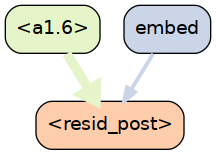

0 --------------------------------------------------
No edge 290
290
No edge 290
New metric: 1.372251033782959
No edge 290
No edge 290
No edge 290
We moved to  blocks.1.attn.hook_result[:, :, 5]
No edge 290
No edge 290
But it's bad
We moved to  blocks.1.attn.hook_result[:, :, 4]
No edge 290
No edge 290
But it's bad
We moved to  blocks.1.attn.hook_result[:, :, 3]
No edge 290
No edge 290
But it's bad
We moved to  blocks.1.attn.hook_result[:, :, 2]
No edge 290
No edge 290
But it's bad
We moved to  blocks.1.attn.hook_result[:, :, 1]
No edge 290
No edge 290
But it's bad
We moved to  blocks.1.attn.hook_result[:, :, 0]
No edge 290
No edge 290
But it's bad
We moved to  blocks.1.attn.hook_v[:, :, 7]
No edge 290
No edge 289
But it's bad
We moved to  blocks.1.attn.hook_v[:, :, 6]
No edge 289


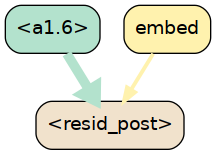

1 --------------------------------------------------
No edge 289
289
No edge 289
New metric: 1.372251033782959

Node: cur_parent=TLACDCInterpNode(blocks.1.hook_v_input, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.1.attn.hook_v, [:, :, 6]))

Metric after removing connection to blocks.1.hook_v_input [:, :, 6] is 7.037415504455566 (and current metric 1.372251033782959)
Result is 5.665164470672607...so keeping connection
No edge 289
We moved to  blocks.1.attn.hook_v[:, :, 5]
No edge 289
No edge 288
But it's bad
We moved to  blocks.1.attn.hook_v[:, :, 4]
No edge 288
No edge 287
But it's bad
We moved to  blocks.1.attn.hook_v[:, :, 3]
No edge 287
No edge 286
But it's bad
We moved to  blocks.1.attn.hook_v[:, :, 2]
No edge 286
No edge 285
But it's bad
We moved to  blocks.1.attn.hook_v[:, :, 1]
No edge 285
No edge 284
But it's bad
We moved to  blocks.1.attn.hook_v[:, :, 0]
No edge 284
No edge 283
But it's bad
We moved to  blocks.1.attn.hook_k[:, :, 7]
No edge 283
No edge 282
But it's b

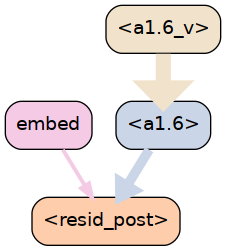

2 --------------------------------------------------
No edge 282
282
No edge 282
New metric: 1.372251033782959

Node: cur_parent=TLACDCInterpNode(blocks.1.hook_k_input, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.1.attn.hook_k, [:, :, 6]))

Metric after removing connection to blocks.1.hook_k_input [:, :, 6] is 11.448685646057129 (and current metric 1.372251033782959)
Result is 10.07643461227417...so keeping connection
No edge 282
We moved to  blocks.1.attn.hook_k[:, :, 5]
No edge 282
No edge 281
But it's bad
We moved to  blocks.1.attn.hook_k[:, :, 4]
No edge 281
No edge 280
But it's bad
We moved to  blocks.1.attn.hook_k[:, :, 3]
No edge 280
No edge 279
But it's bad
We moved to  blocks.1.attn.hook_k[:, :, 2]
No edge 279
No edge 278
But it's bad
We moved to  blocks.1.attn.hook_k[:, :, 1]
No edge 278
No edge 277
But it's bad
We moved to  blocks.1.attn.hook_k[:, :, 0]
No edge 277
No edge 276
But it's bad
We moved to  blocks.1.attn.hook_q[:, :, 7]
No edge 276
No edge 275
But it's 

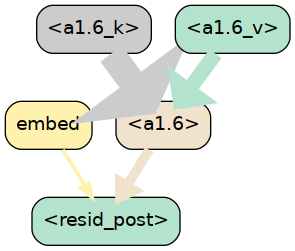

3 --------------------------------------------------
No edge 275
275
No edge 275
New metric: 1.372251033782959

Node: cur_parent=TLACDCInterpNode(blocks.1.hook_q_input, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.1.attn.hook_q, [:, :, 6]))

Metric after removing connection to blocks.1.hook_q_input [:, :, 6] is 12.220121383666992 (and current metric 1.372251033782959)
Result is 10.847870349884033...so keeping connection
No edge 275
We moved to  blocks.1.attn.hook_q[:, :, 5]
No edge 275
No edge 274
But it's bad
We moved to  blocks.1.attn.hook_q[:, :, 4]
No edge 274
No edge 273
But it's bad
We moved to  blocks.1.attn.hook_q[:, :, 3]
No edge 273
No edge 272
But it's bad
We moved to  blocks.1.attn.hook_q[:, :, 2]
No edge 272
No edge 271
But it's bad
We moved to  blocks.1.attn.hook_q[:, :, 1]
No edge 271
No edge 270
But it's bad
We moved to  blocks.1.attn.hook_q[:, :, 0]
No edge 270
No edge 269
But it's bad
We moved to  blocks.1.hook_v_input[:, :, 7]
No edge 269
No edge 260
But it'

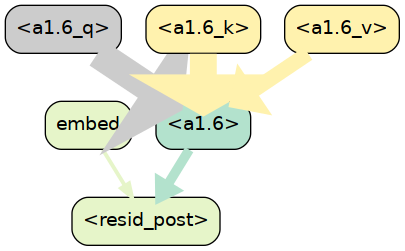

4 --------------------------------------------------
No edge 260
260
No edge 260
New metric: 1.372251033782959

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.1.hook_v_input, [:, :, 6]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 1.6097681522369385 (and current metric 1.372251033782959)
Result is 0.2375171184539795...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.1.hook_v_input, [:, :, 6]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 1] is 1.755074143409729 (and current metric 1.6097681522369385)
Result is 0.14530599117279053...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.1.hook_v_input, [:, :, 6]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 2] is 1.96

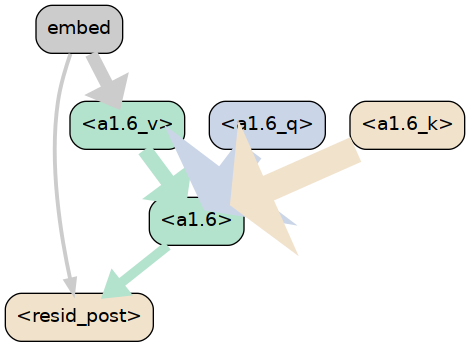

5 --------------------------------------------------
No edge 189
189
No edge 189
New metric: 2.21858811378479

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.1.hook_k_input, [:, :, 6]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 6.5526533126831055 (and current metric 2.21858811378479)
Result is 4.334065198898315...so keeping connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.1.hook_k_input, [:, :, 6]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 1] is 2.276845693588257 (and current metric 2.21858811378479)
Result is 0.0582575798034668...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.1.hook_k_input, [:, :, 6]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 2] is 2.283769130

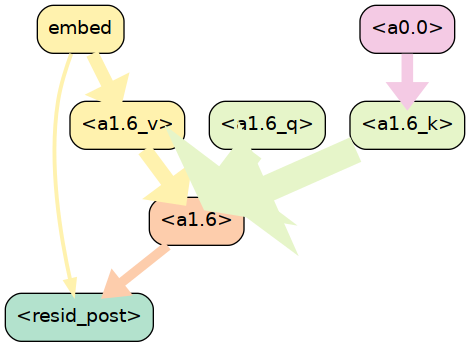

6 --------------------------------------------------
No edge 118
118
No edge 118
New metric: 2.765564203262329

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.1.hook_q_input, [:, :, 6]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 2.7837226390838623 (and current metric 2.765564203262329)
Result is 0.018158435821533203...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.1.hook_q_input, [:, :, 6]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 1] is 2.7686524391174316 (and current metric 2.7837226390838623)
Result is -0.015070199966430664...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.1.hook_q_input, [:, :, 6]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 2] is

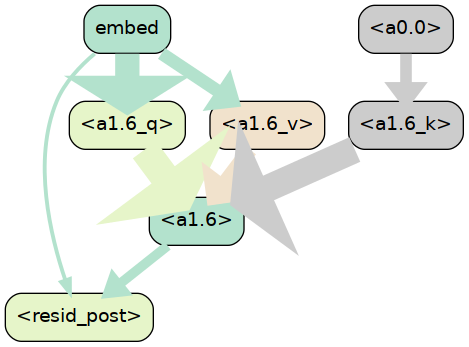

7 --------------------------------------------------
No edge 56
56
No edge 56
New metric: 2.768840789794922
No edge 56
No edge 56
No edge 56
We moved to  blocks.0.attn.hook_v[:, :, 7]
No edge 56
No edge 55
But it's bad
We moved to  blocks.0.attn.hook_v[:, :, 6]
No edge 55
No edge 54
But it's bad
We moved to  blocks.0.attn.hook_v[:, :, 5]
No edge 54
No edge 53
But it's bad
We moved to  blocks.0.attn.hook_v[:, :, 4]
No edge 53
No edge 52
But it's bad
We moved to  blocks.0.attn.hook_v[:, :, 3]
No edge 52
No edge 51
But it's bad
We moved to  blocks.0.attn.hook_v[:, :, 2]
No edge 51
No edge 50
But it's bad
We moved to  blocks.0.attn.hook_v[:, :, 1]
No edge 50
No edge 49
But it's bad
We moved to  blocks.0.attn.hook_v[:, :, 0]
No edge 49


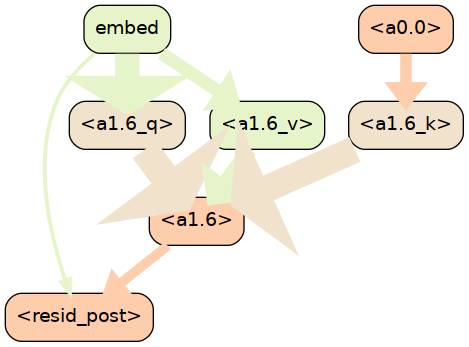

8 --------------------------------------------------
No edge 49
49
No edge 49
New metric: 2.768840789794922

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_v, [:, :, 0]))

Metric after removing connection to blocks.0.hook_v_input [:, :, 0] is 11.442056655883789 (and current metric 2.768840789794922)
Result is 8.673215866088867...so keeping connection
No edge 49
We moved to  blocks.0.attn.hook_k[:, :, 7]
No edge 49
No edge 48
But it's bad
We moved to  blocks.0.attn.hook_k[:, :, 6]
No edge 48
No edge 47
But it's bad
We moved to  blocks.0.attn.hook_k[:, :, 5]
No edge 47
No edge 46
But it's bad
We moved to  blocks.0.attn.hook_k[:, :, 4]
No edge 46
No edge 45
But it's bad
We moved to  blocks.0.attn.hook_k[:, :, 3]
No edge 45
No edge 44
But it's bad
We moved to  blocks.0.attn.hook_k[:, :, 2]
No edge 44
No edge 43
But it's bad
We moved to  blocks.0.attn.hook_k[:, :, 1]
No edge 43
No edge 42
But it's bad
We moved to  b

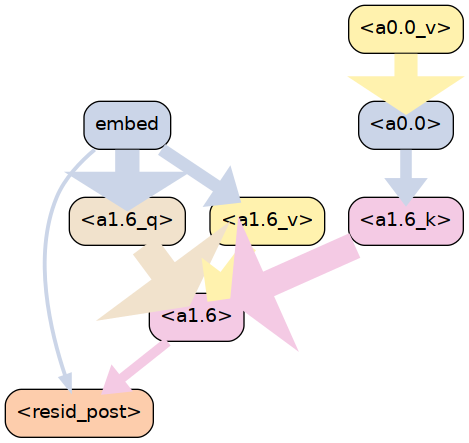

9 --------------------------------------------------
No edge 42
42
No edge 42
New metric: 2.768840789794922

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_k, [:, :, 0]))

Metric after removing connection to blocks.0.hook_k_input [:, :, 0] is 2.764967203140259 (and current metric 2.768840789794922)
Result is -0.003873586654663086...so removing connection
No edge 41
We moved to  blocks.0.attn.hook_q[:, :, 7]
No edge 41
No edge 40
But it's bad
We moved to  blocks.0.attn.hook_q[:, :, 6]
No edge 40
No edge 39
But it's bad
We moved to  blocks.0.attn.hook_q[:, :, 5]
No edge 39
No edge 38
But it's bad
We moved to  blocks.0.attn.hook_q[:, :, 4]
No edge 38
No edge 37
But it's bad
We moved to  blocks.0.attn.hook_q[:, :, 3]
No edge 37
No edge 36
But it's bad
We moved to  blocks.0.attn.hook_q[:, :, 2]
No edge 36
No edge 35
But it's bad
We moved to  blocks.0.attn.hook_q[:, :, 1]
No edge 35
No edge 34
But it's bad
We moved t

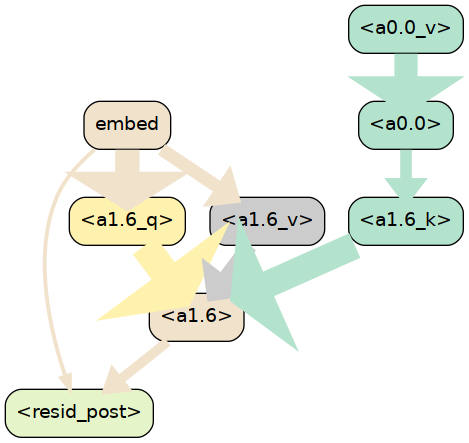

10 --------------------------------------------------
No edge 34
34
No edge 34
New metric: 2.764967203140259

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_q, [:, :, 0]))

Metric after removing connection to blocks.0.hook_q_input [:, :, 0] is 2.7655136585235596 (and current metric 2.764967203140259)
Result is 0.0005464553833007812...so removing connection
No edge 33
We moved to  blocks.0.hook_v_input[:, :, 7]
No edge 33
No edge 32
But it's bad
We moved to  blocks.0.hook_v_input[:, :, 6]
No edge 32
No edge 31
But it's bad
We moved to  blocks.0.hook_v_input[:, :, 5]
No edge 31
No edge 30
But it's bad
We moved to  blocks.0.hook_v_input[:, :, 4]
No edge 30
No edge 29
But it's bad
We moved to  blocks.0.hook_v_input[:, :, 3]
No edge 29
No edge 28
But it's bad
We moved to  blocks.0.hook_v_input[:, :, 2]
No edge 28
No edge 27
But it's bad
We moved to  blocks.0.hook_v_input[:, :, 1]
No edge 27
No edge 26
But it's bad
W

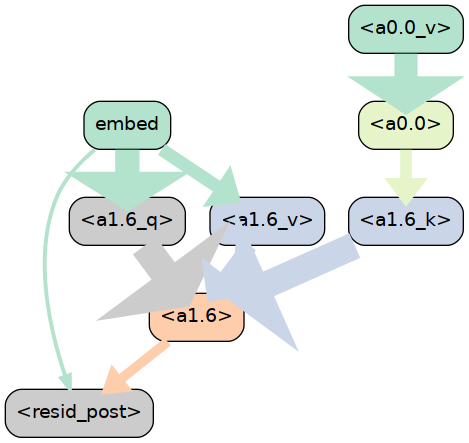

11 --------------------------------------------------
No edge 26
26
No edge 26
New metric: 2.7655136585235596

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_resid_pre, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 0]))

Metric after removing connection to blocks.0.hook_resid_pre [:] is 11.442055702209473 (and current metric 2.7655136585235596)
Result is 8.676542043685913...so keeping connection
No edge 26
We moved to  blocks.0.hook_k_input[:, :, 7]
No edge 26
No edge 25
But it's bad
We moved to  blocks.0.hook_k_input[:, :, 6]
No edge 25
No edge 24
But it's bad
We moved to  blocks.0.hook_k_input[:, :, 5]
No edge 24
No edge 23
But it's bad
We moved to  blocks.0.hook_k_input[:, :, 4]
No edge 23
No edge 22
But it's bad
We moved to  blocks.0.hook_k_input[:, :, 3]
No edge 22
No edge 21
But it's bad
We moved to  blocks.0.hook_k_input[:, :, 2]
No edge 21
No edge 20
But it's bad
We moved to  blocks.0.hook_k_input[:, :, 1]
No edge 20
No edge 19
But it's bad
We moved to

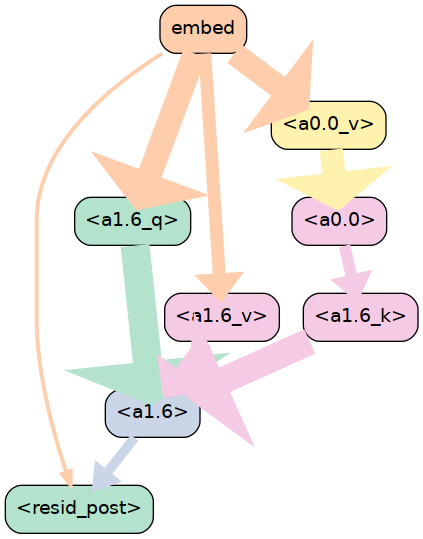

12 --------------------------------------------------
No edge 10
10
No edge 10
New metric: 2.7655136585235596
We moved to  None
No edge 10


/oscar/home/xwang259/Automatic-Circuit-Discovery/acdc/TLACDCExperiment.py:772: UserWarning:

Finished iterating



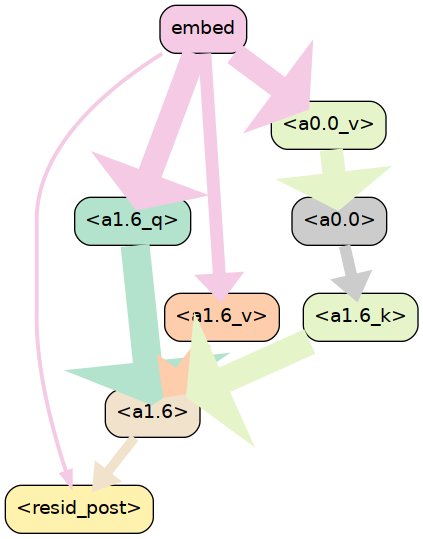

13 --------------------------------------------------
No edge 10
10


In [7]:
for i in range(args.max_num_epochs):
    exp.step(testing=False)

    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=False,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))

    print(i, "-" * 50)
    print(exp.count_no_edges())

    if i == 0:
        exp.save_edges("edges.pkl")

    if exp.current_node is None or SINGLE_STEP:
        break

exp.save_edges("another_final_edges.pkl")

if USING_WANDB:
    edges_fname = f"edges.pth"
    exp.save_edges(edges_fname)
    artifact = wandb.Artifact(edges_fname, type="dataset")
    artifact.add_file(edges_fname)
    wandb.log_artifact(artifact)
    os.remove(edges_fname)
    wandb.finish()

<h2>Save the final subgraph of the model</h2>
<p>There are more than `exp.count_no_edges()` here because we include some "placeholder" edges needed to make ACDC work that don't actually matter</p>
<p>Also note that the final image has more than 12 edges, because the edges from a0.0_q and a0.0_k are not connected to the input</p>
<p>We recover minimal induction machinery! `embed -> a0.0_v -> a1.6k`</p>

In [8]:
exp.save_subgraph(
    return_it=True,
)

OrderedDict([(('blocks.1.hook_resid_post',
               (None,),
               'blocks.1.attn.hook_result',
               (None, None, 6)),
              True),
             (('blocks.1.hook_resid_post',
               (None,),
               'blocks.0.hook_resid_pre',
               (None,)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_q',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_k',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_v',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_q',
               (None, None, 6),
               'blocks.1.hook_q_input',
               (None, None, 6)),
              True),
        